### Import nessasery libraries

In [4]:
!pip install matplotlib

  Using cached matplotlib-3.5.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached setuptools_scm-6.3.2-py3-none-any.whl (33 kB)
  Using cached fonttools-4.28.2-py3-none-any.whl (880 kB)
  Using cached tomli-1.2.2-py3-none-any.whl (12 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
!python -m pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip3 install keras-tuner

  Using cached keras_tuner-1.1.0-py3-none-any.whl (98 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten , Input
from tensorflow.keras.optimizers import Adam, Adamax , RMSprop , SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler , ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    Dropout,
    Input, 
    Concatenate,
    GlobalAveragePooling2D, 
    GlobalMaxPooling2D,
)
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
#sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report
from IPython.core.display import display, HTML
# import the necessary package
from tensorflow.keras.callbacks import EarlyStopping

### plot sample images from the train dataset

>  display 25 images with it's corresponding target label COVID or NON COVID

In [8]:
def show_image_samples(gen):
    class_dict=gen.class_indices  # get the class dict from the train generator {0:"COVID",1:"NONCOVID"}
    class_names=list( class_dict.keys())       
    images,labels=next(gen) # get a sample batch from the generator  ( batch_size , 224,224,3 )
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)   # plot image
        index=np.argmax(labels[i])  # get the target label index
        class_name=class_names[index]   # get the target label name from the label dict
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show() # plot the image samples

### plot the model training statistics accuracy and loss

> train accuracy , loss plots

> validation accuracy , loss plots

> identify the best epoch which generate best accuracy results

In [9]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']  # get the train accuracy stats
    tloss=tr_data.history['loss']     # get the train loss stats
    vacc=tr_data.history['val_accuracy'] # get the validation accuracy stats
    vloss=tr_data.history['val_loss']    # get the validation loss stats
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    
    # iterate over every epoch
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)   #  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]  # get the lowest validation loss value
    index_acc=np.argmax(vacc)     # index for validation accuracy value
    acc_highest=vacc[index_acc]   # get the highest validation accuracy value
    
    plt.style.use('fivethirtyeight')
    # define the labels to add into the plots
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    
    # plot train and validation loss curves
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # plot the train and validation accuracy curves
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    # display the plots
    plt.show()

### display a sample image 

(512, 512)


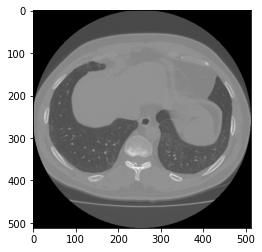

In [10]:
fpath=r'curated_data/curated_data/NonCOVID/16_Morozov_study_0001_12.png'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img , cmap='gray')

### read the file list with target and generate a dataframe

In [11]:
sdir=r'curated_data/curated_data'
filepaths=[]
labels=[]
# list the directories insdie the folder
classlist=os.listdir(sdir)
# iterate over every class
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)  # get the image file names from the folder
    for f in flist:
        # append the image file path into a list
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        # append the target into a list
        labels.append(klass)
        
# generate a data frame object 
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)

print (df.head())
balance=df['labels'].value_counts()
print (balance)

                                           filepaths    labels
0  curated_data/curated_data/NonCOVID/16_Morozov_...  NonCOVID
1  curated_data/curated_data/NonCOVID/6_Rahimzade...  NonCOVID
2  curated_data/curated_data/NonCOVID/6_Rahimzade...  NonCOVID
3  curated_data/curated_data/NonCOVID/16_Morozov_...  NonCOVID
4  curated_data/curated_data/NonCOVID/16_Morozov_...  NonCOVID
COVID       7594
NonCOVID    6894
Name: labels, dtype: int64


### balance the dataset

> since the COVID having 7593 samples , NONCOVID 6894 samples , dataset is imbalance . objective is to balance the dataset 

In [12]:
# get the file count need to use
file_count = 6893
samples = []
# iterate over every category type
for category in df['labels'].unique():
    # get the data slice specific into a category
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))

# generate the new balanced dataframe
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples

COVID       6893
NonCOVID    6893
Name: labels, dtype: int64


### define the train , validation and test dataframe and save into csv files

In [13]:
# split the dataset into 80% train , 10% valid , 10% test data
train_split=.8
valid_split=.1
dummy_split=valid_split/(1.0-train_split)

train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

# save the dataframes into csv files
train_df.to_csv("covid19_train.csv" , index=False)
valid_df.to_csv("covid19_validation.csv", index=False)
test_df.to_csv("covid19_test.csv", index=False)

### define the data generator objects

> initialize the dataset image shapes (224,224,3)

> define hyperparameters , data augmentation methods (train , test)

In [14]:
# define the image target shape
height=224
width=224
channels=3
# define the batch size for model training and validation
batch_size=60

# define image shape
img_shape=(height, width, channels)
img_size=(height, width)

# define a normalization function 
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

# define train imagegenerator object with normalization , shear , zoom and random flip
train_gen=ImageDataGenerator(preprocessing_function=scalar , 
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
# define the test imagegenerator only with the noramlization method
test_gen=ImageDataGenerator(preprocessing_function=scalar)

# define the train dataset from the above define data frames
"""
    train_df : defined input dataframe
    x_col : first column with image paths
    y_col : target column
    target_size : since the dataset can have different shapes , standardize them into (224,224,3)
    class_mode : categorical

"""
train_dataset=train_gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

valid_dataset=test_gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)


test_dataset=test_gen.flow_from_dataframe( test_df,  x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

# define the train , avlid , test steps ( number of batches in the dataset)
train_steps=int(len(train_dataset.labels)/batch_size)
test_steps=int(len( test_df )/batch_size) 
valid_steps = int( len(valid_df)/batch_size )

/usr/local/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 11027 validated image filenames belonging to 2 classes.
Found 1379 validated image filenames belonging to 2 classes.
Found 1379 validated image filenames belonging to 2 classes.


> define the tuning dataset

In [15]:
tunner_df, _ =train_test_split(df, train_size= 0.4 , shuffle=True, random_state=123)

tunner_dataset=train_gen.flow_from_dataframe( tunner_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
tunner_valid_dataset = valid_dataset

Found 5513 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


### plot sample set of images from train data generator

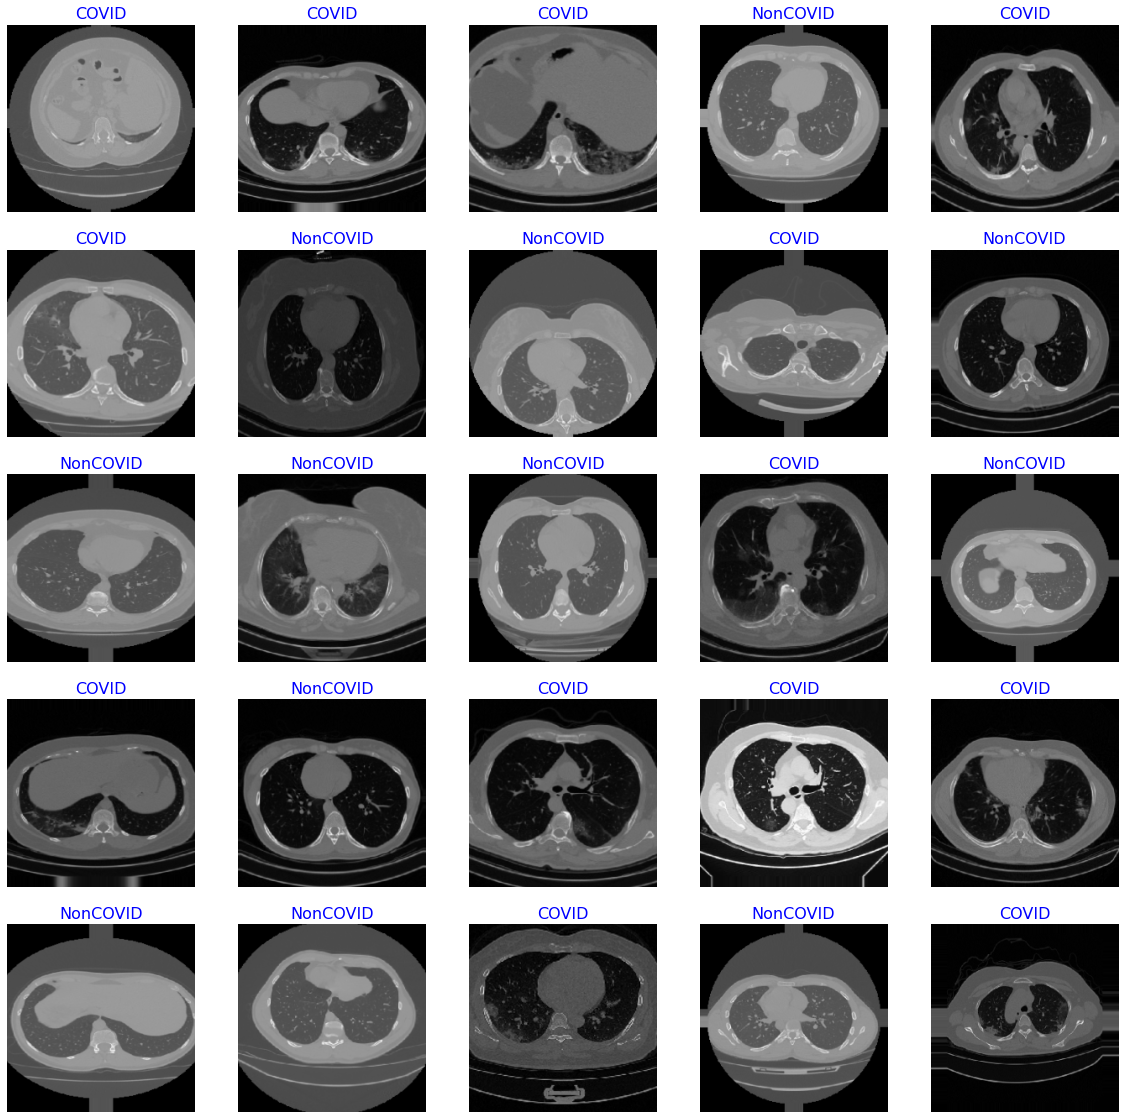

In [16]:
# plot the samples
show_image_samples(train_dataset)

### Define the Model for image classification

* main target is to adopt a pre trained InceptionResNetV2 model using trasnfer learning method
* main advantage is model having capability to extract low level featuers very accurately
* fine tunning model adjest the  weights according to the current dataset

> hyperparameter tunning

In [17]:
def build_model(hp):
    # initialize the model along with the input shape and channel
    # dimension
    
    # get the class ditionary {0:"COVID",1:"NonCOVID"}
    class_dict=train_dataset.class_indices
    classes=list( class_dict.keys()) 
    # get the number of classes for adding into the final classifcation dense layer
    class_count=len(classes)
    model_name='InceptionResNetV2'

    # initialize the inceptionresnetv2 model from keras model repository
    base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
    x=base_model.output
    # add batchnoarmalization layers
    x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

    # add a dense layer with 256-768 neurons
    x =Dense( hp.Int("dense_units", min_value=256,
              max_value=768, step=256) , kernel_regularizer = regularizers.l2(l = 0.016) , 
             bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    # add dropout layer with 0.3 probabaility for prevent model overfitting
    x=Dropout( hp.Float("dropout_rate", min_value=0.2,
              max_value=0.4, step=0.1) , seed=123)(x)  
    
    # add final classification layer with softmax activation and 2 neurons
    output=Dense(class_count, activation='softmax')(x)
    # encapsulate the model inside the Model class
    model=Model(inputs=base_model.input, outputs=output)
    
    # initialize the learning rate choices and optimizer
    lr = hp.Choice("learning_rate",
        values=[ 1e-2, 1e-3])
    opt = Adam(learning_rate=lr)

    # compile the model
    model.compile(optimizer=opt, loss="categorical_crossentropy",
        metrics=["accuracy"])

    # return the model
    return model

> define hyperparameter tunning

In [18]:
import kerastuner as kt

class Config:
    # define the path to our output directory
    OUTPUT_PATH = "keras_tuner"

    # define the total number of epochs to train, batch size, and the
    # early stopping patience
    EPOCHS = 5
    BS = 32
    EARLY_STOPPING_PATIENCE = 5

# instantiate an object of the configuration class
config = Config()

print("[INFO] instantiating a random search tuner object...")
tuner = kt.RandomSearch(
            build_model,
            objective="val_accuracy",
            max_trials=10,
            seed=42,
            directory=config.OUTPUT_PATH,
            project_name="tuner_inception")

[INFO] instantiating a random search tuner object...
INFO:tensorflow:Reloading Oracle from existing project keras_tuner/tuner_inception/oracle.json


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


[2021-11-24 01:00:11.989 tensorflow-2-3-gpu--ml-g4dn-xlarge-857ba94c8ff520cf618cce107153:24 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-11-24 01:00:12.014 tensorflow-2-3-gpu--ml-g4dn-xlarge-857ba94c8ff520cf618cce107153:24 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
INFO:tensorflow:Reloading Tuner from keras_tuner/tuner_inception/tuner0.json


INFO:tensorflow:Reloading Tuner from keras_tuner/tuner_inception/tuner0.json


> define best parameters

In [19]:
# initialize an early stopping callback to prevent the model from
# overfitting/spending too much time training with minimal gains
es = EarlyStopping(
        monitor="val_loss",
        patience=config.EARLY_STOPPING_PATIENCE,
        restore_best_weights=True)

# perform the hyperparameter search
print("[INFO] performing hyperparameter search...")
tuner.search(
        tunner_dataset ,
        validation_data=tunner_valid_dataset ,
        batch_size=config.BS,
        callbacks=[es],
        epochs=config.EPOCHS
)

[INFO] performing hyperparameter search...
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [20]:
# grab the best hyperparameters
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of units in dense layer: {}".format(
        bestHP.get("dense_units")))
print("[INFO] optimal number for dropout layer: {}".format(
        bestHP.get("dropout_rate")))
print("[INFO] optimal learning rate: {:.4f}".format(
        bestHP.get("learning_rate")))

[INFO] optimal number of units in dense layer: 256
[INFO] optimal number for dropout layer: 0.2
[INFO] optimal learning rate: 0.0010


## define Inception model

In [21]:
# get the class ditionary {0:"COVID",1:"NonCOVID"}
class_dict=train_dataset.class_indices
classes=list( class_dict.keys()) 
# get the number of classes for adding into the final classifcation dense layer
class_count=len(classes)
model_name='InceptionResNetV2'

def Inception_model():

    # initialize the inceptionresnetv2 model from keras model repository
    base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
    x=base_model.output
    # add batchnoarmalization layers
    x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    # add a dense layer with 256 neurons
    x =Dense(256, kernel_regularizer = regularizers.l2(l = 0.016) , bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    # add dropout layer with 0.3 probabaility for prevent model overfitting
    x=Dropout(rate=.2, seed=123)(x)        
    # add final classification layer with softmax activation and 2 neurons
    output=Dense(class_count, activation='softmax')(x)
    # encapsulate the model inside the Model class
    model=Model(inputs=base_model.input, outputs=output)
    # define the learning rate for the optimization method
    initial_learning_rate = .001
    """
    compile the model with      Adamax optimizer 
                                loss : categorical crossentropy
                                metrics : accuracy
    """ 
    model.compile( SGD(lr= initial_learning_rate ,
                          momentum=0.9 , ), loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

## define vgg16 model

In [22]:
def vgg16_model(): 
    
    VGG = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    for layer in VGG.layers[:-5]:
      layer.trainable = False
    for layer in VGG.layers[-5:]:
      layer.trainable = True
    
    input = Input(shape=(224, 224, 3))
    
    x = VGG( input , training=False )
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense( class_count , activation="softmax")(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

## define resnet 50 model

In [23]:
def resnet50_model(): 
    
    VGG = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    for layer in VGG.layers[:-5]:
      layer.trainable = False
    for layer in VGG.layers[-5:]:
      layer.trainable = True
    
    input = Input(shape=(224, 224, 3))
    
    x = VGG( input , training=False )
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense( class_count , activation="softmax")(x)
 
    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

## define the model from above three models
> comment out the model that need to train and test

In [29]:
# initialize the model from above functions
#model =  Inception_model()  #--> uncomment this model to train and test inception 
model = Inception_model()  # uncomment this model to train and test vgg16
#model = resnet50_model() # uncomment this model to train and test resnet50

### train the model and validate 

In [ ]:
import math

epochs =20

"""
define the learning rate decau , which reduce the learning rate as model training , because when model trains 
upto a certen level optimization steps need to be reduced otherwise model will not converge into optimal level
"""
initial_learning_rate = .001
def lr_step_decay(epoch, lr):
    drop_rate = 0.8
    epochs_drop = 3.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# initialize an early stopping callback to prevent the model from
# overfitting/spending too much time training with minimal gains
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True)

# define a checkpoint object to save the best model
checkpoint = ModelCheckpoint('covid19_classification_model.h5', verbose=0, save_best_only=True)
callbacks=[LearningRateScheduler(lr_step_decay, verbose=0) , checkpoint , es ]

# train the model using train set and validate using validation set
history=model.fit(x=train_dataset,  epochs=epochs, verbose=1 , callbacks =  callbacks ,  validation_data=valid_dataset,
                shuffle=False,  initial_epoch=0)

Epoch 1/20
184/184 [==============================] - 200s 1s/step - loss: 6.9974 - accuracy: 0.8579 - val_loss: 6.4643 - val_accuracy: 0.9239
Epoch 2/20
184/184 [==============================] - 196s 1s/step - loss: 6.0860 - accuracy: 0.9332 - val_loss: 5.7082 - val_accuracy: 0.9449
Epoch 3/20
184/184 [==============================] - 196s 1s/step - loss: 5.3758 - accuracy: 0.9551 - val_loss: 5.0636 - val_accuracy: 0.9558
Epoch 4/20
184/184 [==============================] - 194s 1s/step - loss: 4.8126 - accuracy: 0.9639 - val_loss: 4.6008 - val_accuracy: 0.9616
Epoch 5/20
184/184 [==============================] - 194s 1s/step - loss: 4.3712 - accuracy: 0.9711 - val_loss: 4.1868 - val_accuracy: 0.9688
Epoch 6/20
184/184 [==============================] - 197s 1s/step - loss: 3.9678 - accuracy: 0.9792 - val_loss: 3.8169 - val_accuracy: 0.9688
Epoch 7/20
184/184 [==============================] - 195s 1s/step - loss: 3.6413 - accuracy: 0.9812 - val_loss: 3.5285 - val_accuracy: 0.9761

### plot the train and validation stats and evalute the model on test dataset

In [ ]:
# plot the model training and validation stats
tr_plot(history, 0)
# evalute the model using test set
acc=model.evaluate(test_dataset,batch_size=batch_size, steps=test_steps, verbose=1)[1]*100

### visualize the model results on test dataset

In [ ]:
def print_info( test_gen, preds ):
    # define the class dictionary from data geerators
    class_dict=test_dataset.class_indices
    labels= test_dataset.labels
    y_pred=[]
    new_dict ={}
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    
    # get the predicted labels from model predictions
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        y_pred.append(pred_index)    
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred) 
        # get the confusion matrix using y_true , y_pred
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

### visualize the model performance report on test dataset

In [ ]:
print_code=0
preds=model.predict(test_dataset) 
print_info( test_gen, preds )  